# Define Model

In [1]:
# PDE_model.py

import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('D://downloads')

class ForestFirePDE: # PDE model to simulate fire spread in forest

    def __init__(self, k, epsilon, alpha, u_pc, q, spatial_length,spatial_resolution, temporal_length, delta_t):
        '''
        Initialize the simulation with parameters.
        
        k: diffusion coefficient 
        epsilon:  inverse of activation energy of fuel
        alpha: natural convection
        u_pc: phase change threshold
        q: reaction heat
        spatial_length: map length
        spatial_resolution: simulation mash length
        temporal_length: number of dt, total simulation time = temporal_length * delta_t
        delta_t: dt
        wind_x / wind_y: the effect of wind (and topography if any)
        '''
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.u_pc = u_pc
        self.q = q
        self.spatial_length = spatial_length
        self.spatial_resolution = spatial_resolution
        self.dx = spatial_length / spatial_resolution
        self.dy = self.dx
        self.temporal_length = temporal_length
        self.delta_t = delta_t
        
        # Initialize maps for temperature (u_t) and fuel (beta_t)
        self.u_t = np.zeros((temporal_length, spatial_resolution, spatial_resolution), dtype=np.float64)
        self.beta_t = np.zeros((temporal_length, spatial_resolution, spatial_resolution), dtype=np.float64)
        
    def init_conditions(self):
        # Initial conditions for temperature (Gaussian centered near the middle), and for fuel (uniformly random)
        x, y = np.meshgrid(np.linspace(0, self.spatial_length , self.spatial_resolution),
                           np.linspace(0, self.spatial_length , self.spatial_resolution))   
        
        self.wind_x = np.cos(0.04 * x + np.pi / 4)
        self.wind_y = np.sin(0.01 * y + np.pi / 4)
        
        self.u_t[0] = 6 * np.exp(-0.05 * ((x - 60)**2 + (y - 20)**2))
        self.beta_t[0] = np.random.uniform(0, 1, (self.spatial_resolution, self.spatial_resolution))     
        
    def boundary_conditions(self, t):
        # Apply zero boundary conditions to temperature and fuel
        self.u_t[t, 0, :] = self.u_t[t, -1, :] = 0
        self.u_t[t, :, 0] = self.u_t[t, :, -1] = 0
        self.beta_t[t, 0, :] = self.beta_t[t, -1, :] = 0
        self.beta_t[t, :, 0] = self.beta_t[t, :, -1] = 0
    
    def laplacian_operator(self, map_x):
        # Compute the Laplacian with second-order finite differences
        laplace_map = np.zeros_like(map_x)
        laplace_map[1:-1, 1:-1] = (
            map_x[2:, 1:-1] + map_x[:-2, 1:-1] + map_x[1:-1, 2:] + map_x[1:-1, :-2] - 4 * map_x[1:-1, 1:-1]
        ) / (self.dx ** 2)
        return laplace_map
    
    def gradient_operator(self, map_x):
        # Compute the gradient using finite differences
        grad_x = np.zeros_like(map_x)
        grad_y = np.zeros_like(map_x)
        
        grad_x[:, 1:-1] = (map_x[:, 2:] - map_x[:, :-2]) / (2.0 * self.dx)        
        grad_y[1:-1, :] = (map_x[2:, :] - map_x[:-2, :]) / (2.0 * self.dx)

        
        return grad_x, grad_y
    
    def heaviside_step_function(self, x):
        return np.where(x >= self.u_pc, 1, 0)
    
    def update(self):
        for t in range(1, self.temporal_length):
            # Calculate Laplacian for diffusion and gradients for convection
            u = self.u_t[t-1]
            beta = self.beta_t[t-1]
            lap_u = self.laplacian_operator(u)
            grad_u_x, grad_u_y = self.gradient_operator(u)

            # Compute convection term
            convection = -(self.wind_x * grad_u_x + self.wind_y * grad_u_y)

            # Update temperature
            f_u_beta = self.heaviside_step_function(u) * beta * np.exp(u / (1 + self.epsilon * u)) - self.alpha * u
            self.u_t[t] = u + self.delta_t * (self.k * lap_u + convection + f_u_beta)

            # Update fuel
            g_u_beta = -self.heaviside_step_function(u) *  self.epsilon /  self.q * beta * np.exp(u / (1 + self.epsilon * u))
            self.beta_t[t] = beta + self.delta_t * g_u_beta

            # Apply boundary conditions
            self.boundary_conditions(t)

    def plot_t_and_f(self,cur_time,save = True):

        plt.figure(figsize=(6, 5))


        plt.imshow(self.u_t[int(cur_time / self.delta_t)], cmap='jet', interpolation='nearest', vmin=-2, vmax=6, origin='lower')
        plt.colorbar(label=r'Temperature')

        X, Y = np.meshgrid(np.arange(0, self.spatial_resolution, 7), np.arange(0, self.spatial_resolution, 7))            
        
        U = self.wind_x[::7, ::7]  # Downsample wind_x for visualization
        V = self.wind_y[::7, ::7]  # Downsample wind_y for visualization

        plt.quiver(X, Y, U, V, color='black')
        
        plt.title(r"Temperature (u) at Time = " + str(cur_time))
        plt.xlabel(r"x")
        plt.ylabel(r"y")

        plt.xticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_length / 2),self.spatial_length])
        plt.yticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_length / 2),self.spatial_length])
        
        if save == True:
            plt.savefig('temperature_time' + str(cur_time))
            
        plt.show()


        plt.figure(figsize=(6, 5))
        plt.imshow(self.beta_t[int(cur_time/self.delta_t)], cmap='copper', interpolation='nearest', origin='lower')
        plt.colorbar(label='Fuel')

        plt.title("Fuel (u) at Time = " + str(cur_time))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_length / 2),self.spatial_length])
        plt.yticks([0,self.spatial_resolution / 2,self.spatial_resolution],[0,int(self.spatial_length / 2),self.spatial_length])
        
        if save == True:
            plt.savefig('fuel_time' + str(cur_time))
            
        plt.show()

    
    def run(self):
        self.init_conditions()
        self.update()
        return self.u_t, self.wind_x, self.wind_y

# Run Simulation

In [2]:
# Parameters
k = 0.1
epsilon = 0.3
alpha = 0.001
u_pc = 3
q = 1
spatial_length = 90
spatial_resolution = 128
temporal_length = 1000
delta_t = 25/500

# Run the simulation
model = ForestFirePDE(k, epsilon, alpha, u_pc, q, spatial_length,spatial_resolution, temporal_length,delta_t)
a,b,c = model.run()


# Plot Simulation

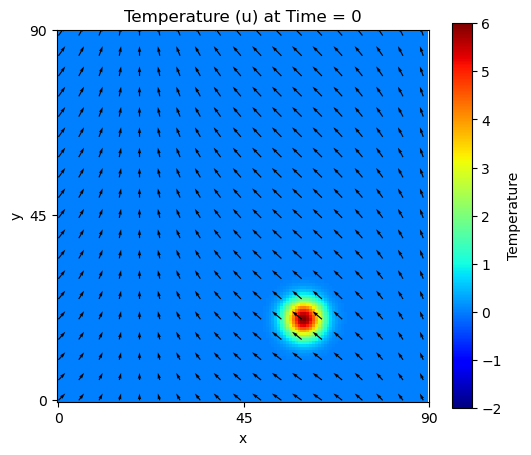

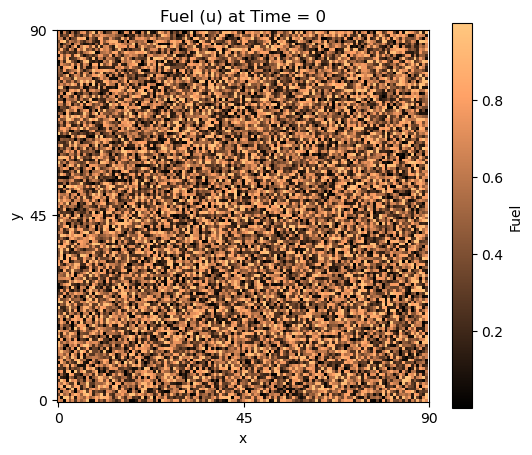

In [3]:
model.plot_t_and_f(0)

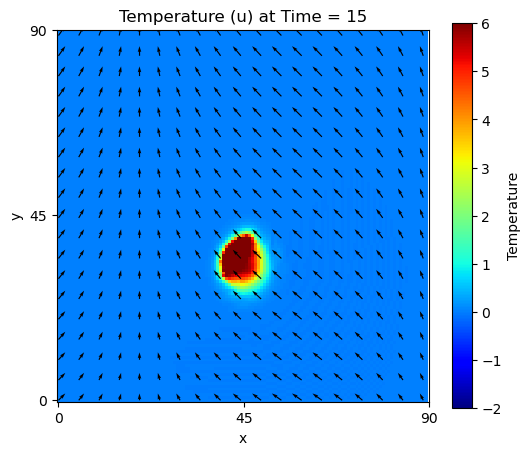

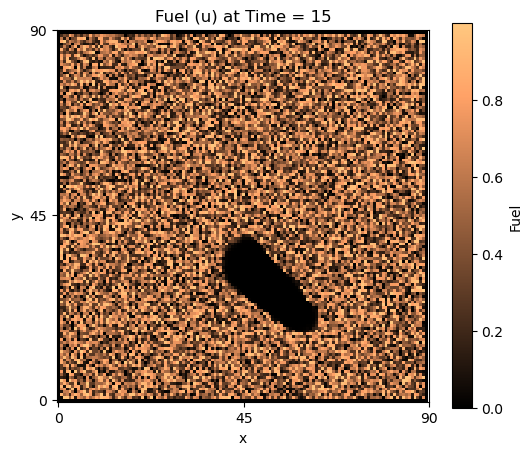

In [4]:
model.plot_t_and_f(15)

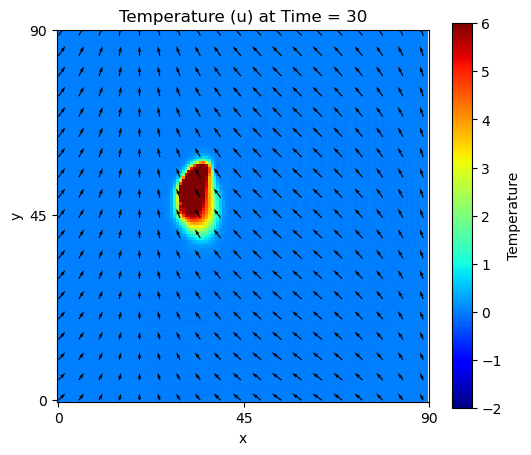

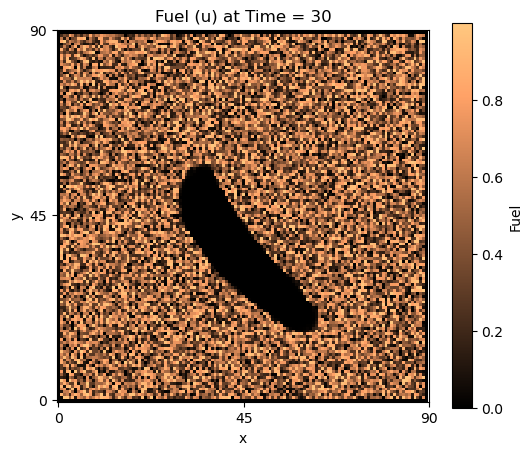

In [5]:
model.plot_t_and_f(30)